# Importamos todas las lisbrerias y claves

In [1]:
from iol_user_ullua import *

iol_user = USER
iol_password = PASS

In [2]:
import datetime, requests, time
import pandas as pd
import numpy as np
from IPython.display import clear_output
import pickle

In [3]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Entrenar Machine Learning

## Bajamos data historica

In [4]:
def downloadTiingo(symbol, _from, _to, interval='1min'):
    clear_output(wait=True)
    TOKEN = '3e63d74be68b49e14fb4c161c378b6250ad8d5c3'
    url = f'https://api.tiingo.com/iex/{symbol}/prices'
    headers = {'Content-Type': 'application/json'}
    params = {'startDate':_from, 'endDate':_to, 'resampleFreq':interval, 'token':TOKEN }
    r = requests.get(url, params=params, headers=headers)
    df = pd.DataFrame(r.json()).set_index('date')
    print('Datos recabados ok hasta el: ', _to)
    return df

In [5]:
desde = datetime.date(2017,1,1)
hasta = datetime.date(2020,12,11)

fechas = []
while desde < hasta+datetime.timedelta(days=35):
    fechas.append(desde.isoformat())
    desde += datetime.timedelta(days=35)

rangos = list(zip(fechas[:-1],fechas[1:]))
dfs = [downloadTiingo('GGAL', _from=rango[0], _to=rango[1], interval='1min') for rango in rangos]
data = pd.concat(dfs)

Datos recabados ok hasta el:  2021-01-10


## La guardamos

In [6]:
with open('historicos_GGAL.dat', 'wb') as file:
    pickle.dump(data,file)

## La recuperamos

In [7]:
with open('historicos_GGAL.dat', 'rb') as file:
    data = pickle.load(file)

data

,close,high,low,open
date,,,,
2017-01-03T14:37:00.000Z,27.720,27.720,27.720,27.720
2017-01-03T14:38:00.000Z,27.720,27.720,27.720,27.720
2017-01-03T14:39:00.000Z,27.720,27.720,27.720,27.720
2017-01-03T14:40:00.000Z,27.720,27.720,27.720,27.720
2017-01-03T14:41:00.000Z,27.720,27.720,27.720,27.720
...,...,...,...,...
2020-12-11T17:53:00.000Z,9.005,9.005,9.005,9.005
2020-12-11T17:54:00.000Z,9.005,9.005,9.005,9.005
2020-12-11T17:55:00.000Z,9.005,9.005,9.005,9.005


## Generamos indicadores para ML

In [8]:
def generarIndicadores(data):
    df = (data['close']+data['open']+data['high']+data['low'])/4
    cruces = [(2,20),(2,40),(2,60),(2,100),(2,200),(5,20),(5,50),(5,100),(5,200),(5,400),(10,20),(10,50),(10,100),
             (10,200),(10,500),(20,50),(20,100),(20,200),(20,500),(20,1000),(50,100),(50,200),(50,500),(50,1000),
             (100,200),(100,400),(100,500),(100,1000),(200,500),(200,1000),(400,1000)]

    df = df.to_frame().apply(pd.to_numeric)
    df.columns = ['px']
    for cruce in cruces:
        clave = str(cruce[0]) + '_' + str(cruce[1])
        df[clave] = (df.px.rolling(cruce[0]).mean() / df.px.rolling(cruce[1]).mean() -1)*100

    pd.options.display.max_columns=15
    df['fw_20'] = (df.px.shift(-20) / df.px -1)*100

    df = df.dropna().round(4)
    return df

df = generarIndicadores(data)

In [9]:
valor_critico_fw = df.fw_20.quantile(0.5)
valor_critico_fw

0.0

In [10]:
# % medio de las que acierta
res_medio_win = df.loc[df.fw_20 > valor_critico_fw].fw_20.mean()
res_medio_win

0.6152736716074294

In [11]:
# & medio de las que pifia
res_medio_loss = df.loc[df.fw_20 <= valor_critico_fw].fw_20.mean()
res_medio_loss

-0.45666214538130007

In [12]:
df['pred'] = np.where(df.fw_20 > valor_critico_fw ,1 ,0)
df

,px,2_20,2_40,2_60,2_100,2_200,5_20,...,100_500,100_1000,200_500,200_1000,400_1000,fw_20,pred
date,,,,,,,,,,,,,,,
2017-01-05T18:14:00.000Z,28.4500,0.3766,0.5420,0.5973,0.7663,1.1495,0.3766,...,0.2334,0.2087,-0.1463,-0.1709,-0.1315,0.3339,1
2017-01-05T18:15:00.000Z,28.4500,0.3412,0.5243,0.5854,0.7547,1.1417,0.3412,...,0.2440,0.2177,-0.1396,-0.1658,-0.1310,0.3339,1
2017-01-05T18:16:00.000Z,28.4500,0.3059,0.5065,0.5736,0.7431,1.1340,0.3059,...,0.2546,0.2266,-0.1329,-0.1608,-0.1304,0.3339,1
2017-01-05T18:17:00.000Z,28.4500,0.2705,0.4888,0.5617,0.7315,1.1263,0.2705,...,0.2652,0.2355,-0.1263,-0.1558,-0.1299,0.3339,1
2017-01-05T18:18:00.000Z,28.5450,0.3857,0.6303,0.7121,0.8847,1.2857,0.2853,...,0.2785,0.2475,-0.1185,-0.1494,-0.1289,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-11T17:33:00.000Z,8.9888,-0.4561,-0.4805,-0.6998,-1.0192,-2.1664,-0.4575,...,-1.0042,1.3014,0.1567,2.4893,2.6939,0.1808,1
2020-12-11T17:34:00.000Z,8.9900,-0.4313,-0.4681,-0.6770,-0.9996,-2.1483,-0.4271,...,-1.0238,1.2779,0.1382,2.4669,2.6853,0.1669,1
2020-12-11T17:35:00.000Z,8.9900,-0.3995,-0.4488,-0.6509,-0.9731,-2.1237,-0.4023,...,-1.0434,1.2545,0.1199,2.4448,2.6764,0.1669,1


In [13]:
df.groupby('pred').size()

pred
0    222422
1    164955
dtype: int64

In [14]:
df.groupby('pred').size() / len(df)

pred
0    0.574175
1    0.425825
dtype: float64

## Entrenamos un modelo

Wall time: 3min 8s


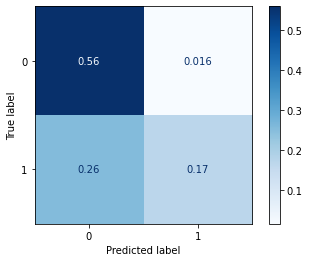

In [15]:
%%time
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:-2], df.pred, test_size=0.2)

modelo_rf = RandomForestClassifier(criterion = 'entropy', max_depth=15)
modelo_rf.fit(X_train, y_train)
y_pred = modelo_rf.predict(X_test)
with open('bot_rf.dat', 'wb') as file:
    pickle.dump(modelo_rf,file)

m = np.array(skm.confusion_matrix(y_test, y_pred, normalize='all'))
skm.plot_confusion_matrix(modelo_rf, X_test, y_test, normalize='all', cmap='Blues')

## Levantamos el modelo entrenado

In [16]:
with open('bot_rf.dat', 'rb') as file:
    modelo_rf = pickle.load(file)

## Calculo de la esperanza matematica:

OBVIO HAY QUE HACER UN BACKTEST COMO LA GENTE, ES UNA SIMPLIFICACION ESTO

In [17]:
prob_pifiar = m[0,1]/(m[0,1]+m[1,1])
prob_acertar =  m[1,1]/(m[0,1]+m[1,1])
E = prob_acertar * res_medio_win + prob_pifiar * res_medio_loss
E

0.5236494816077658

# Funciones para BOT

## Funciones ML & predicción

In [18]:
def traerModelo(tipo='RF'):
    if tipo=='RF':
        with open('bot_rf.dat', 'rb') as file:
            modelo = pickle.load(file)
    else: 
        modelo = None

    return modelo

In [23]:
def downloadTiingo(symbol, _from, _to, interval='1min'):
    clear_output(wait=True)
    try:
        TOKEN = '3e63d74be68b49e14fb4c161c378b6250ad8d5c3'
        url = f'https://api.tiingo.com/iex/{symbol}/prices'
        headers = {'Content-Type': 'application/json'}
        params = {'startDate':_from, 'endDate':_to, 'resampleFreq':interval, 'token':TOKEN }
        r = requests.get(url, params=params, headers=headers)
        df = pd.DataFrame(r.json()).set_index('date')
        print('Datos recabados ok hasta el: ', _to)
        return df
    except:
        print(f'No se pudo descargar desde Tiingo data de {symbol}')
        return None

In [24]:
def generarIndicadores(data):
    try:
        df = (data['close']+data['open']+data['high']+data['low'])/4
        cruces = [(2,20),(2,40),(2,60),(2,100),(2,200),(5,20),(5,50),(5,100),(5,200),(5,400),(10,20),(10,50),(10,100),
                 (10,200),(10,500),(20,50),(20,100),(20,200),(20,500),(20,1000),(50,100),(50,200),(50,500),(50,1000),
                 (100,200),(100,400),(100,500),(100,1000),(200,500),(200,1000),(400,1000)]

        df = df.to_frame().apply(pd.to_numeric)
        df.columns = ['px']
        for cruce in cruces:
            clave = str(cruce[0]) + '_' + str(cruce[1])
            df[clave] = (df.px.rolling(cruce[0]).mean() / df.px.rolling(cruce[1]).mean() -1)*100

        pd.options.display.max_columns=15
        df['fw_20'] = (df.px.shift(-20) / df.px -1)*100

        df = df.dropna().round(4)
        return df
    except:
        print('No se pudieron generar indicadores')
        return None

In [25]:
def traerData(symbol, days=5, interval='1min'):
    try:
        hasta = datetime.datetime.now()
        desde = hasta - datetime.timedelta(days=days)
        data = downloadTiingo(symbol, desde, hasta, interval=interval)
        return data
    except:
        print(f'No se pudo traer la data de {symbol} de los ultimos {days} dias')
        return None

In [26]:
def predecir(data, modelo):
    try:
        actual = generarIndicadores(data).iloc[-1,1:-1]
        y_pred = modelo.predict((actual,))[0]
        y_proba = modelo.predict_proba((actual,))[0]
        return y_pred, y_proba
    except:
        print('No se pudo predecir')
        return None, None

## Funciones de Ruteo

In [27]:
def pedirToken():
    url = 'https://api.invertironline.com/token'
    data = {"username" : iol_user, "password": iol_password, "grant_type":"password"}
    tk  = requests.post(url = url, data = data).json()
    return tk

In [28]:
def actualizarToken():
    global tk
    exp = datetime.datetime.strptime(tk['.expires'],'%a, %d %b %Y %H:%M:%S GMT')
    ahora = datetime.datetime.utcnow()
    tiempo = exp-ahora

    if tiempo.days != 0:
        print('Actualizando Token')
        tk = pedirToken()

    print('Token actualizado')

In [29]:
def precioIOL(mercado, ticker):    
    actualizarToken() 
    url_base= 'https://api.invertironline.com/api/v2/'
    endpoint = mercado+'/Titulos/'+ticker+'/Cotizacion'
    url = url_base + endpoint
    headers = {"Authorization" : "Bearer "+ tk['access_token']}
    data = requests.get(url = url, headers = headers).json()    
    return data

In [30]:
def comprar(ticker, q, precio, plazo ):
    actualizarToken()     
    vigencia = datetime.datetime.now() + datetime.timedelta(days=1)
    vigencia_str =datetime.datetime.strftime(vigencia, '%Y-%m-%d')
    params = {
      "mercado": "bCBA",
      "simbolo": ticker,
      "cantidad": q,
      "precio": precio,
      "plazo": plazo,
      "validez": vigencia_str
    }
    url_base= 'https://api.invertironline.com/api/v2/'
    endpoint = 'operar/comprar/'
    url = url_base + endpoint
    headers = {"Authorization" : "Bearer "+ tk['access_token']}    
    data = requests.post(url = url, headers = headers, json = params).json()
    return data

In [31]:
def vender(ticker, q, precio, plazo ):
    actualizarToken()     
    vigencia = datetime.datetime.now() + datetime.timedelta(days=1)
    vigencia_str = datetime.datetime.strftime(vigencia, '%Y-%m-%d')
    params = {
      "mercado": "bCBA",
      "simbolo": ticker,
      "cantidad": q,
      "precio": precio,
      "plazo": plazo,
      "validez": vigencia_str
    }
    url_base= 'https://api.invertironline.com/api/v2/'
    endpoint = 'operar/vender/'
    url = url_base + endpoint
    headers = {"Authorization" : "Bearer "+ tk['access_token']}    
    data = requests.post(url = url, headers = headers, json = params).json()
    return data

In [32]:
def compraAgresiva(symbol):
    data = precioIOL('bcba',symbol)
    punta_bid = data['puntas'][0]['precioCompra']
    punta_ask = data['puntas'][0]['precioVenta']
    id_compra = comprar(ticker=symbol, q=1, precio = punta_ask, plazo='t2')
    return id_compra

def ventaAgresiva(symbol):
    data = precioIOL('bcba',symbol)
    punta_bid = data['puntas'][0]['precioCompra']
    punta_ask = data['puntas'][0]['precioVenta']
    id_venta = vender(ticker=symbol, q=1, precio = punta_bid, plazo='t2')
    return id_venta

## Funciones del demonio

In [33]:
def portafolio(pais):
    actualizarToken()     
    url_base= 'https://api.invertironline.com/api/v2/'
    endpoint = 'portafolio/'+pais
    url = url_base + endpoint
    headers = {"Authorization" : "Bearer "+ tk['access_token']}
    data = requests.get(url = url, headers = headers).json()    
    return(data['activos'])

In [34]:
def consultarTenencia(symbol):
    port = portafolio('Argentina')
    encontrados = sum([x['cantidad'] for x in port if x['titulo']['simbolo']==symbol])
    tenencia = True if encontrados > 0 else False
    return tenencia

## Pruebo las funciones

In [35]:
tk = pedirToken() # Solo al iniciar el bot una sola vez

In [36]:
actualizarToken() # antes de cada request a la API (En las funciones)

Token actualizado


In [37]:
modelo = traerModelo('RF')
data = traerData('GGAL')
prediccion = predecir(data, modelo)
prediccion

Datos recabados ok hasta el:  2020-12-11 15:15:58.712554


(0, array([0.55216678, 0.44783322]))

In [38]:
# compraAgresiva('GGAL')

# BOT

## Definicion de constantes

In [39]:
# USA arranca 11:30 (hora invernal USA) pero dejamos los primeros 5min libres
# ARG corta 17hs, dejamos por las dudas 5min para operaciones de cierre final a posteriori

HORA_INICIO_BOT = 11.5833 
HORA_FIN_BOT = 16.55

## Funcion principal

In [40]:
def ejecutar():
    ahora = datetime.datetime.now()
    hora_decimal = round(ahora.hour + ahora.minute/60 + ahora.second/3600 ,5)
    clear_output(wait=True)
    print(f'Ejecutando a las, {hora_decimal}, se termina a las {HORA_FIN_BOT}')
    time.sleep(1)

## Deamon: el demonio

In [42]:
HORA_INICIO_BOT = 15.29
HORA_FIN_BOT = 15.30
    
while True:
    ahora = datetime.datetime.now()
    hora_decimal = round(ahora.hour + ahora.minute/60 + ahora.second/3600,5)
    
    if hora_decimal < HORA_INICIO_BOT:
        clear_output(wait=True)
        print(f'Esperando a las {HORA_INICIO_BOT}, Son las:',hora_decimal)
        time.sleep(1)
        # Aca puede ejecutar tareas de preparacion de rueda
        
    else:
        if hora_decimal < HORA_FIN_BOT:
            ejecutar()
            
        else:
            clear_output(wait=True)
            print(f'Son las {hora_decimal}, fin de horario de operaciones: {HORA_FIN_BOT}')

            # Aca puede ejecutar tareas de finalizacion del dia
            break


Son las 15.3, fin de horario de operaciones: 15.3
